In [41]:
# Run this cell without modification
import numpy as np
import torch
from utils import *
import torch
import torch.nn as nn
from random import randint, choice
from IPython.display import clear_output
from collections import deque
import matplotlib.pyplot as plt
import math
import random

In [42]:
class UAVEnvironment():
    """
    Game environment for UAV test
    
    ---Map---
    
    y-axis(length)
    |
    |
    |
    |
    |
    |
     _______________________ x-axis(width)
     
    Hight is a fixed value
    
    """
    def __init__(self, config):
        # Game config
        self.action_space = (0, 1, 2, 3) # up, right, down, left, total 4 actions
        self.total_steps = config["total_steps"] # when the game end
        self.current_step = 0
        if config["is_random_env"] == False:
            self.random_seed = config["random_seed"]
            random.seed(self.random_seed)
        
        # Map config
        self.map = dict(width=config["map"]["width"], length=config["map"]["length"], height=config["map"]["height"])
        self.UAV_speed = config["UAV_speed"]
        self.UAV_initial_pos = config["UAV_initial_pos"] 
        self.inital_state=config["initial_state"]
        self.UAV_current_pos = self.UAV_initial_pos
        self.number_of_user = config["number_of_user"]
        self.users_pos = list()
        self.UAV_path = [] # record the path of UAV
        for i in range(0, self.number_of_user):
            self.users_pos.append((randint(0, self.map["width"]), randint(0, self.map["length"])))
        
        # Wireless config
        self.g0 = config["wireless_parameter"]["g0"]
        self.B = config["wireless_parameter"]["B"]
        self.Pk = config["wireless_parameter"]["Pk"]
        self.noise = config["wireless_parameter"]["noise"]
        
    def get_reward(self,prev_pos, UAV_pos):
        reward = 0
        for user_index in range(0, self.number_of_user):
            gkm = self.g0 / (self.map["height"] ** 2 + (UAV_pos[0] - self.users_pos[user_index][0]) ** 2 + (UAV_pos[1] - self.users_pos[user_index][1]) ** 2)
            user_utility = (self.B/self.number_of_user)* math.log(1 + self.Pk * gkm / self.noise, 2)
            reward = reward + user_utility
        return (reward) / (10 ** 6) # Use Mkbps as signal basic unit
    
 
    def transition_dynamics(self, action, speed, state):
        # given the action (direction), calculate the next state (UAV current position)
        assert action in self.action_space
        next_UAV_pos = list(state)
        if action == 0:
            # move up
            next_UAV_pos[1] = min(next_UAV_pos[1] + speed, self.map["length"])
        if action == 1:
            # move right
            next_UAV_pos[0] = min(next_UAV_pos[0] + speed, self.map["width"])
        if action == 2:
            # move down
            next_UAV_pos[1] = max(next_UAV_pos[1] - speed, 0)
        if action == 3:
            # move left
            next_UAV_pos[0] = max(next_UAV_pos[0] - speed, 0)
        return np.array(next_UAV_pos)
                    
    def step(self, action, speed=-1):
        # assume we use the max speed as the default speed, when come near to the opt-position, we can slow down the speed
        if speed < 0 or speed >= self.UAV_speed:
            speed = self.UAV_speed
        
        prev_pos=self.UAV_current_pos
        #update pos
        self.UAV_path.append(prev_pos)
        self.UAV_current_pos = self.transition_dynamics(action, speed, self.UAV_current_pos)
        self.current_step = self.current_step + 1
        done = False
        if self.current_step == self.total_steps:
            done =  True
        state=self.UAV_current_pos/1000
        return state, self.get_reward(prev_pos, self.UAV_current_pos), done
    
    def action_sample(self):
        return choice(self.action_space)
    
    def reset(self):
        self.current_step = 0
        self.UAV_current_pos = self.UAV_initial_pos
        return self.UAV_current_pos
        
    def print_attribute(self):
        attrs = vars(self)
        print(', '.join("%s: %s" % item for item in attrs.items()))
        
    def print_locations(self):
        print("UAV position is: {}".format(self.UAV_current_pos))
        print("Users position are: {}".format(self.users_pos))
        
    def print_map(self):
        x_list = [pos[0] for pos in self.users_pos]
        y_list = [pos[1] for pos in self.users_pos]
        x_list.append(self.UAV_current_pos[0])
        y_list.append(self.UAV_current_pos[1])
        for i in range(0, len(self.UAV_path)):
            x_list.append(self.UAV_path[i][0])
            y_list.append(self.UAV_path[i][1])
        
        colors = np.array(["red", "green", "blue"])
        sizes = []
        colors_map = []
        for i in range(0, self.number_of_user):
            sizes.append(25)
            colors_map.append(1)
        sizes.append(50)
        colors_map.append(0)
        for i in range(0, len(self.UAV_path)):
            sizes.append(10)
            colors_map.append(2)
        for i in range(0, len(self.UAV_path) - 1):
            x_values = [self.UAV_path[i][0], self.UAV_path[i+1][0]]
            y_values = [self.UAV_path[i][1], self.UAV_path[i+1][1]]
            plt.plot(x_values, y_values, 'b')
        plt.scatter(x_list, y_list, c=colors[colors_map], s=sizes) 
        plt.axis([0, self.map["width"], 0, self.map["length"]])
        plt.show()
        

In [52]:
# Run this cell without modification
environment_config = dict(
    total_steps = 50,
    random_seed = 10,
    is_random_env = False,
    map=dict(
        width=1000,
        length=1000,
        height=300
    ),
    number_of_user = 10,
    UAV_speed = 50,
    UAV_initial_pos = np.array([0, 0]),
    initial_state=0,
    wireless_parameter = dict(
        g0 = 10 ** (-5),
        B = 10 ** (6),
        Pk = 0.1,
        noise = 10 ** (-9)
    )
)


def evaluate(policy, num_episodes=1, render=False):
    global environment_config
    env = UAVEnvironment(environment_config)
    rewards = []
    if render: num_episodes = 1
    for i in range(num_episodes):
        obs = env.reset()
        act = policy(obs)
        ep_reward = 0
        while True:
            obs, reward, done = env.step(act)
            act = policy(obs)
            ep_reward += reward
            if render:
                clear_output(wait=True)
                env.print_attribute()
                print("Current Step: {}".format(env.current_step))
                print("Action: {}".format(act))
                print("UAV current position x: {}, y: {}".format(env.UAV_current_pos[0], env.UAV_current_pos[1]))
                print("Current step reward: {}, episodes rewards: {}".format(reward, ep_reward))
                env.print_map()
                wait(sleep=0.2)
            if done:
                break
        rewards.append(ep_reward)
    return np.mean(rewards)

def run(trainer_cls, config=None, reward_threshold=None):
    assert inspect.isclass(trainer_cls)
    if config is None:
        config = {}
    trainer = trainer_cls(config)
    config = trainer.config
    start = now = time.time()
    stats = []
    for i in range(config['max_iteration'] + 1):
        stat = trainer.train()
        stats.append(stat or {})
        if i % config['evaluate_interval'] == 0 or \
                i == config["max_iteration"]:
            reward = trainer.evaluate(config.get("evaluate_num_episodes", 50))
            print("({:.1f}s,+{:.1f}s)\tIteration {}, current mean episode "
                  "reward is {}. {}".format(
                time.time() - start, time.time() - now, i, reward,
                {k: round(np.mean(v), 4) for k, v in
                 stat.items()} if stat else ""))
            now = time.time()
        if reward_threshold is not None and reward > reward_threshold:
            print("In {} iteration, current mean episode reward {:.3f} is "
                  "greater than reward threshold {}. Congratulation! Now we "
                  "exit the training process.".format(
                i, reward, reward_threshold))
            break
    return trainer, stats


def to_tensor(x):
    """A helper function to transform a numpy array to a Pytorch Tensor"""
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).type(torch.float32)
    assert isinstance(x, torch.Tensor)
    if x.dim() == 3 or x.dim() == 1:
        x = x.unsqueeze(0)
    assert x.dim() == 2 or x.dim() == 4, x.shape
    return x

def to_long_tensor(x):
    """A helper function to transform a numpy array to a Pytorch Tensor"""
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).type(torch.long)
    assert isinstance(x, torch.Tensor)
    if x.dim() == 3 or x.dim() == 1:
        x = x.unsqueeze(0)
    assert x.dim() == 2 or x.dim() == 4, x.shape
    return x

class ExperienceReplayMemory:
    """Store and sample the transitions"""
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class PytorchModel(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super(PytorchModel, self).__init__()
        self.action_value = torch.nn.Sequential(
            torch.nn.Linear(obs_dim,100),
            torch.nn.ReLU(),
            torch.nn.Linear(100,100),
            torch.nn.ReLU(),
            torch.nn.Linear(100,act_dim),
        )

    def forward(self, obs):
        return self.action_value(obs)

In [53]:
pytorch_config = dict(
    max_iteration=1000,
    max_episode_length=1000,
    evaluate_interval=100,
    gamma=0.99,
    eps=0.3,
    parameter_std=0.01,
    learning_rate=0.01,
    hidden_dim=100,
    clip_norm=1.0,
    clip_gradient=True,
    memory_size=50000,
    learn_start=5000,
    batch_size=32,
    target_update_freq=500,  # in steps
    learn_freq=1,  # in steps
    n=1
)

class DQNTrainer():
    def __init__(self, config):
        self.config = merge_config(config, pytorch_config)
        self.env = UAVEnvironment(config)
        self.act_dim=4
        self.obs_dim=2 
        self.eps = self.config['eps']
        self.hidden_dim = self.config["hidden_dim"]
        self.max_episode_length = self.config["max_episode_length"]
        self.learning_rate = self.config["learning_rate"]
        self.gamma = self.config["gamma"]
        self.n = self.config["n"]
        self.initialize_parameters()
        self.learning_rate = self.config["learning_rate"]
        self.learn_start = self.config["learn_start"]
        self.batch_size = self.config["batch_size"]
        self.target_update_freq = self.config["target_update_freq"]
        self.clip_norm = self.config["clip_norm"]
        self.step_since_update = 0
        self.total_step = 0
        self.memory = ExperienceReplayMemory(self.config["memory_size"])

    def initialize_parameters(self):
        self.network = PytorchModel(self.obs_dim,self.act_dim)
        self.network.eval()
        self.network.share_memory()
        self.target_network = PytorchModel(self.obs_dim,self.act_dim)
        self.target_network.load_state_dict(self.network.state_dict())
        self.target_network.eval()

        self.optimizer = torch.optim.Adam(
            self.network.parameters(), lr=self.learning_rate
        )
        self.loss = nn.MSELoss()

    def compute_values(self, processed_state):
        values=self.network(processed_state)
        return values.data.numpy()

    def train(self):
        s = self.env.reset()
        processed_s = self.process_state(s)
        act = self.compute_action(processed_s)
        stat = {"loss": []}
        for t in range(self.max_episode_length):
            next_state, reward, done = self.env.step(act)
            next_processed_s = self.process_state(next_state)
            self.memory.push((processed_s, act, reward, next_processed_s, done))
            processed_s = next_processed_s
            act = self.compute_action(next_processed_s)
            self.step_since_update += 1
            self.total_step += 1

            if done:
                break
            if t % self.config["learn_freq"] != 0:
                continue
            if len(self.memory) < self.learn_start:
                continue
            elif len(self.memory) == self.learn_start:
                print("Current memory contains {} transitions, "
                      "start learning!".format(self.learn_start))

            batch = self.memory.sample(self.batch_size)
            state_batch = to_tensor( np.stack([transition[0] for transition in batch]))
            action_batch = to_long_tensor(np.stack([transition[1] for transition in batch]))
            reward_batch = to_tensor(np.stack([transition[2] for transition in batch]))
            next_state_batch = torch.stack([transition[3] for transition in batch])
            done_batch = to_tensor(np.stack([transition[4] for transition in batch]))

            with torch.no_grad():
                next_state_values=self.target_network(next_state_batch)
                Q_t_plus_one = next_state_values.max(1)[0].detach()             
                assert isinstance(Q_t_plus_one, torch.Tensor)
                assert Q_t_plus_one.dim() == 1
                Q_target = reward_batch+(1-done_batch)*Q_t_plus_one
            self.network.train()
            
            state_action_values=self.network(state_batch)
            Q_t = torch.t(state_action_values).gather(0,action_batch)
            assert Q_t.shape == Q_target.shape
            self.optimizer.zero_grad()
            loss = self.loss(input=Q_t, target=Q_target)
            loss_value = loss.item()
            stat['loss'].append(loss_value)
            loss.backward()
            nn.utils.clip_grad_norm_(self.network.parameters(), self.clip_norm)   
            self.optimizer.step()
            self.network.eval()

        if len(self.memory) >= self.learn_start and self.step_since_update > self.target_update_freq:
            self.step_since_update = 0
            self.target_network.load_state_dict(self.network.state_dict())
            self.target_network.eval()
        return {"loss": np.mean(stat["loss"]), "episode_len": t}
    
    def compute_action(self, processed_state, eps=None):
        values = self.compute_values(processed_state)
        assert values.ndim == 1, values.shape
        if eps is None:
            eps = self.eps
        if np.random.uniform(0,1)< eps:
            action=self.env.action_sample()
        else:
            action=np.argmax(values)
        return action

    def compute_activation(self, processed_state):
        activation = np.dot(self.hidden_parameters.T,processed_state)
        return activation

    def compute_gradient(self, processed_states, actions, rewards, tau, T):
        n = self.n
        G = 0
        for i in range(tau+1,min(T,tau+n)+1):
            G+=np.power(self.gamma,i-tau-1)*rewards[i]
        if tau + n < T:
            Q_tau_plus_n = self.compute_values(processed_states[tau+n])
            act=actions[tau+n]  
            G = G + (self.gamma ** n) * Q_tau_plus_n[act]
        cur_state = processed_states[tau]
        loss_grad = np.zeros((self.act_dim, 1))  # [act_dim, 1]
        q=self.compute_values(cur_state)
        act=actions[tau]
        loss_grad[act]=-(G-q[act])

        activation=self.compute_activation(cur_state)
        activation=np.array([activation])
        output_gradient = np.dot(activation.T,loss_grad.T)
  
        assert np.all(np.isfinite(output_gradient)), \
            "Invalid value occurs in output_gradient! {}".format(
                output_gradient)
        assert np.all(np.isfinite(hidden_gradient)), \
            "Invalid value occurs in hidden_gradient! {}".format(
                hidden_gradient)
        return [hidden_gradient, output_gradient]

    def apply_gradient(self, gradients):
        """Apply the gradientss to the two layers' parameters."""
        assert len(gradients) == 2
        hidden_gradient, output_gradient = gradients
        assert output_gradient.shape == (self.hidden_dim, self.act_dim)
        assert hidden_gradient.shape == (self.obs_dim, self.hidden_dim)
        if self.config["clip_gradient"]:
            clip_norm = self.config["clip_norm"]
            output_gradient=output_gradient*clip_norm/max(clip_norm, np.linalg.norm(output_gradient))
            hidden_gradient=hidden_gradient*clip_norm/max(clip_norm, np.linalg.norm(hidden_gradient))

        self.output_parameters-= self.learning_rate*output_gradient
        self.hidden_parameters-= self.learning_rate*hidden_gradient

    def evaluate(self, num_episodes=50, *args, **kwargs):
        policy = lambda raw_state: self.compute_action(
            self.process_state(raw_state), eps=0.0)
        result = evaluate(policy, num_episodes, *args, **kwargs)
        return result
    
    def process_state(self, state):
        return torch.from_numpy(state).type(torch.float32)

In [54]:
config=merge_config(environment_config, dict(
    max_iteration=1000,
    evaluate_interval=100, 
    learning_rate=0.0001,
    clip_norm=10.0,
    memory_size=50000,
    learn_start=1000,
    eps=0.03,
    target_update_freq=1000,
    batch_size=32,
))
pytorch_trainer, pytorch_stat = run(DQNTrainer, config,reward_threshold=5) #,reward_threshold=2

reward = pytorch_trainer.evaluate()


(0.5s,+0.5s)	Iteration 0, current mean episode reward is 0.1947482809852421. {'loss': nan, 'episode_len': 49.0}
(12.8s,+12.3s)	Iteration 100, current mean episode reward is 0.16357544228636653. {'loss': 0.0004, 'episode_len': 49.0}
(29.5s,+16.7s)	Iteration 200, current mean episode reward is 0.1947482809852421. {'loss': 0.0006, 'episode_len': 49.0}
(51.1s,+21.6s)	Iteration 300, current mean episode reward is 0.1947482809852421. {'loss': 0.0008, 'episode_len': 49.0}
(65.4s,+14.3s)	Iteration 400, current mean episode reward is 0.2062009020572017. {'loss': 0.0009, 'episode_len': 49.0}
(82.8s,+17.4s)	Iteration 500, current mean episode reward is 0.1947482809852421. {'loss': 0.0009, 'episode_len': 49.0}
(99.5s,+16.7s)	Iteration 600, current mean episode reward is 0.3334058177332664. {'loss': 0.001, 'episode_len': 49.0}
(116.1s,+16.5s)	Iteration 700, current mean episode reward is 0.1947482809852421. {'loss': 0.0016, 'episode_len': 49.0}
(130.9s,+14.8s)	Iteration 800, current mean episode re

action_space: (0, 1, 2, 3), total_steps: 50, current_step: 50, random_seed: 10, map: {'width': 1000, 'length': 1000, 'height': 300}, UAV_speed: 50, UAV_initial_pos: [0 0], inital_state: 0, UAV_current_pos: [1000  300], number_of_user: 10, users_pos: [(585, 33), (439, 494), (591, 15), (211, 473), (832, 503), (843, 284), (669, 830), (164, 35), (533, 501), (335, 77)], UAV_path: [array([0, 0]), array([50,  0]), array([100,   0]), array([150,   0]), array([200,   0]), array([250,   0]), array([300,   0]), array([350,   0]), array([400,   0]), array([450,   0]), array([500,   0]), array([550,   0]), array([600,   0]), array([650,   0]), array([700,   0]), array([750,   0]), array([800,   0]), array([850,   0]), array([850,  50]), array([900,  50]), array([900, 100]), array([950, 100]), array([950, 150]), array([1000,  150]), array([1000,  200]), array([1000,  250]), array([1000,  300]), array([1000,  300]), array([1000,  300]), array([1000,  300]), array([1000,  300]), array([1000,  300]), a

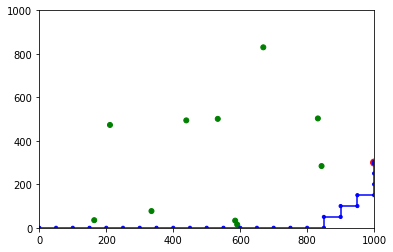

Average episode reward for your Pytorch agent:  0.2551598532986239


In [55]:

print("Average episode reward for your Pytorch agent: ",
      pytorch_trainer.evaluate(1, render=True))